In [1]:
import numpy as np
import tensorflow as tf
from utils import constants
from utils.utils import model_accuracy
from utils.custom_layers import WeightedAverageLayer
from sklearn.metrics import classification_report

from keras import layers
from keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess_input

2022-11-22 00:55:02.706869: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
img_size = (224,224)
shape = (224,224,3)

In [3]:
class_names = ["basal","melanoma","squamous","misc"]
class_names = sorted(class_names) # Sorting them
name_id_map = dict(zip(range(len(class_names)),class_names))
id_name_map = dict(zip(class_names,range(len(class_names))))
print(name_id_map)

{0: 'basal', 1: 'melanoma', 2: 'misc', 3: 'squamous'}


In [4]:
def class_precision(confusion_matrix, class_number):
    tp = confusion_matrix[class_number][class_number]
    fn = sum(confusion_matrix[i][class_number] for i in range(len(confusion_matrix[0])))
    return tp/fn

def class_recall(confusion_matrix, class_number):
    tp = confusion_matrix[class_number][class_number]
    fn = sum(confusion_matrix[class_number][i] for i in range(len(confusion_matrix[0])))
    return tp/fn

In [5]:
def predict_images(model, generator):
    predictions = model.predict(generator)
    filenames = generator.filenames
    true_labels = []
    predicted_labels = []
    true_predictions = []
    true_pos = 0
    neg = 0
    temp = np.zeros(4)
    for (prediction, file) in zip(predictions, filenames):
        label = np.argmax(prediction, axis = -1)
        true_label = file.split('/')[0]
        true_labels.append(true_label)
        predicted_labels.append(name_id_map[label])
        temp[label] = 1
        true_predictions.append(temp)
        temp = np.zeros(4)
        if name_id_map[label] == true_label:
            true_pos += 1        
        else:
            neg += 1
    return true_pos, neg, predictions, true_labels, predicted_labels, true_predictions

In [7]:
efficient = load_model('EfficientNet.h5')
resnet = load_model("ResNet.h5")
vgg = load_model("VGG16.h5")

# VGG


In [8]:

vgg_datagen = ImageDataGenerator(preprocessing_function = vgg_preprocess_input)
vgg_generator = vgg_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  


#pos, neg, pred, true_labels, pred_labels, true_predictions = predict_images(vgg, vgg_generator)
#print(classification_report(true_labels, pred_labels))

Found 742 images belonging to 4 classes.


# ResNet

In [9]:

resnet_datagen = ImageDataGenerator(preprocessing_function = resnet_preprocess_input)
resnet_generator = resnet_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  

#pos, neg, pred, true_labels, pred_labels, true_predictions = predict_images(resnet, resnet_generator)
#print(classification_report(true_labels, pred_labels))

Found 742 images belonging to 4 classes.


# Efficient Net

In [10]:
efficient_datagen = ImageDataGenerator()
efficient_generator = efficient_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  
#pos, neg, pred, true_labels, pred_labels, true_predictions = predict_images(efficient, efficient_generator)
#print(classification_report(true_labels, pred_labels))

Found 742 images belonging to 4 classes.


# Ensembles

In [11]:
def ensembleModels(models, model_input, w1,w2,w3):
    # collect outputs of models in a list
        # averaging outputs
    yAvg = WeightedAverageLayer(w1,w2,w3)(models)     # build model from same input and avg output
    modelEns = tf.keras.models.Model(inputs=model_input, outputs=yAvg,name='ensemble')  
   
    return modelEns

In [12]:
# Weighted Average Model using accuracy on validation set
def model_accuracy_average():

    model_input = layers.Input((224,224,3))    
    
    #vgg_input = vgg_preprocess_input(model_input)
    #resnet_input = resnet_preprocess_input(model_input)

    efficient_acc = model_accuracy("EfficientNet")
    resnet_acc = model_accuracy("ResNet")
    vgg_acc = model_accuracy("VGG16")
    total = efficient_acc + resnet_acc + vgg_acc
    efficient_acc /= total
    resnet_acc /= total
    vgg_acc /= total

    print(efficient_acc,resnet_acc,vgg_acc)

    models = [vgg(model_input),resnet(model_input),efficient(model_input)]

    modelEnsemble = ensembleModels(models,model_input,1,1,1)
    modelEnsemble.summary()
   
    return modelEnsemble

In [22]:
# Weighted Average Model using accuracy on validation set
def model_ranked_average():

    model_input = layers.Input((224,224,3))    
    
    vgg_input = vgg_preprocess_input(model_input)
    resnet_input = resnet_preprocess_input(model_input)

    eff_acc = 3
    res_acc = 2
    vgg16_acc = 1
    total = eff_acc + res_acc + vgg16_acc
    eff_acc /= total
    res_acc /= total
    vgg16_acc /= total


    print(eff_acc,res_acc,vgg16_acc)

    models = [vgg(vgg_input),resnet(resnet_input),efficient(model_input)]
    modelEnsemble1 =  ensembleModels(models,model_input,1 ,1, 1)
    modelEnsemble1.summary()
   
    return modelEnsemble1

# Weighted model using accuracy


In [ ]:
accuracy_datagen = ImageDataGenerator()
accuracy_generator = accuracy_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  
model_weighted_accuracy = model_accuracy_average()
pos, neg, pred, true_labels, pred_labels, true_predictions  = predict_images(model_weighted_accuracy, accuracy_generator)
print(classification_report(true_labels, pred_labels))

In [ ]:
import scikitplot as skplt
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, pred, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, pred, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels)

# Weighted model using rank

In [31]:
ranked_datagen = ImageDataGenerator()
ranked_generator = ranked_datagen.flow_from_directory(
                    constants.TEST_DIRECTORY,
                    target_size=img_size,
                    batch_size=1,
                    class_mode='categorical',
                    shuffle = False)  
                    
model_ranked_accuracy = model_ranked_average()
pos, neg, pred, true_labels, pred_labels, true_predictions = predict_images(model_ranked_accuracy, ranked_generator)
print(classification_report(true_labels, pred_labels))

Found 742 images belonging to 4 classes.
0.5 0.3333333333333333 0.16666666666666666
Model: "ensemble"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.__operators__.getitem_6 (Sl  (None, 224, 224, 3)  0          ['input_4[0][0]']                
 icingOpLambda)                                                                                   
                                                                                                  
 tf.__operators__.getitem_7 (Sl  (None, 224, 224, 3)  0          ['input_4[0][0]']                
 icingO

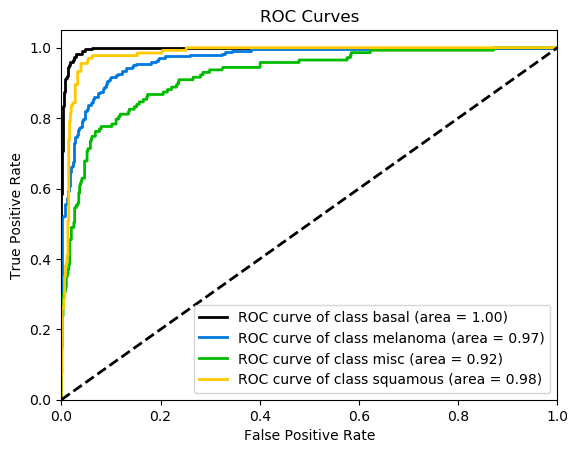

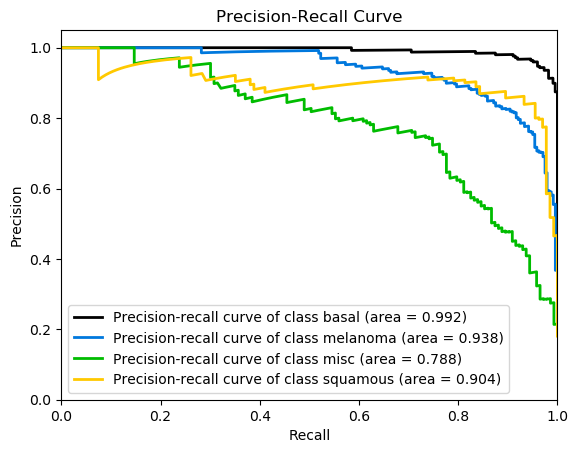

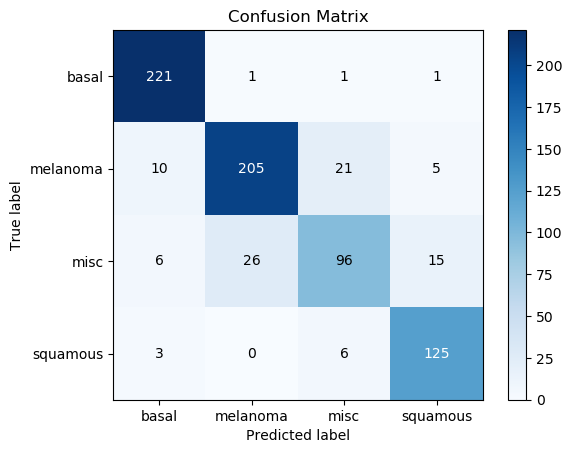

: 

In [32]:
import scikitplot as skplt
y_train = np.array([id_name_map[item] for item in true_labels])
skplt.metrics.plot_roc(true_labels, pred, plot_micro= False, plot_macro=False)
skplt.metrics.plot_precision_recall(true_labels, pred, plot_micro=False)
skplt.metrics.plot_confusion_matrix(true_labels, pred_labels)

# Classification

In [24]:

from tensorflow.keras.utils import load_img, img_to_array, array_to_img
def load_image(img_path):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    #img_tensor /= 255
    
    return img_tensor

In [25]:
def print_predictions(models, img_path):
    for m in models:
        pred = m.predict(load_image(img_path), verbose = 0)
        pred = np.array(pred)
        pred = np.round(pred,3) 
        name = name_id_map[pred.argmax(1)[0]]
        print('Model: ',m.name," Class predicted: ", str.capitalize(name), " Predictions: ", pred, )

In [26]:
img_path = 'database/squamous_images/ISIC_0029549_both.png'

In [27]:
img = load_image(img_path)
img1 = vgg_preprocess_input(img)
img2 = resnet_preprocess_input(img)
print(vgg.predict(img1))
print(resnet.predict(img2))

1/1 [==============================] - 0s 18ms/step
[[0.10139279 0.00342043 0.20661701 0.6885698 ]]
1/1 [==============================] - 0s 20ms/step
[[1.2221035e-04 9.8756266e-01 7.5241798e-03 4.7909566e-03]]


In [28]:
print_predictions([vgg,resnet,efficient,model_ranked_accuracy], img_path)

Model:  VGG16  Class predicted:  Basal  Predictions:  [[0.945 0.007 0.005 0.042]]
Model:  model  Class predicted:  Misc  Predictions:  [[0.192 0.146 0.564 0.097]]
Model:  EfficientNet  Class predicted:  Melanoma  Predictions:  [[0.258 0.432 0.023 0.287]]
Model:  ensemble  Class predicted:  Squamous  Predictions:  [[0.566 0.599 0.079 1.756]]


In [29]:
pred = model_ranked_accuracy.predict(load_image(img_path))
pred = np.array(pred)
print(np.round(pred,3))
y_classes = pred.argmax(axis=-1)
print("Class: ", name_id_map[y_classes[0]])

1/1 [==============================] - 0s 33ms/step
[[0.566 0.599 0.079 1.756]]
Class:  squamous


In [ ]:
pred = model_ranked_accuracy.predict(load_image(img_path))
pred = np.array(pred)
print(np.round(pred,3))
y_classes = pred.argmax(axis=-1)
print("Class: ", name_id_map[y_classes[0]])

In [ ]:
import os
for im in os.listdir('database/squamous_images'):
    im = os.path.join('database/squamous_images',im)
    v = vgg.predict(load_image(im), verbose = 0)
    v = v.argmax(axis=-1)
    v = name_id_map[v[0]]
    r = resnet.predict(load_image(im), verbose = 0)
    r = r.argmax(axis=-1)
    r = name_id_map[r[0]]
    e = efficient.predict(load_image(im), verbose = 0)
    e = e.argmax(axis=-1)
    e = name_id_map[e[0]]
    if v != r and v != e and r != e and e != 'squamous':
        print(im)
    